In [53]:
import os
import sys

from dotenv import load_dotenv

import librosa
import numpy as np
import pandas as pd

import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt

import psycopg2
from psycopg2.extras import DictCursor

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts.fetch_data import fetch_coughs_from_db

load_dotenv()

DB_CREDENTIALS = {
    'user': os.environ['PGUSER'],
    'password': os.environ['PGPASSWORD'],
    'host': os.environ['PGHOST'],
    'database': os.environ['PGDATABASE']
}

## Preprocessing

In [54]:
def get_row(data):
    return {
        "filename": data["filename"],
        "coughing": "coughing" in data["questions"]["symptoms"],
        "fatigue": "fatigue" in data["questions"]["symptoms"],
        "digestive_issues": "digestive_issues" in data["questions"]["symptoms"],
        "body_ache_chills": "body_ache_chills" in data["questions"]["symptoms"],
        "headache": "headache" in data["questions"]["symptoms"],
        "congestion": "congestion" in data["questions"]["symptoms"],
        "shortness_of_breath": "shortness_of_breath" in data["questions"]["symptoms"],
        "fever": "fever" in data["questions"]["symptoms"],
        "positive": data["questions"]["diagnosis"] == "tested_positive_present"
    }

In [55]:
BASE_PATH = "../data"

with psycopg2.connect(**DB_CREDENTIALS, cursor_factory=DictCursor) as conn:
    coughs = fetch_coughs_from_db(conn)

df = []
for c in coughs:
    f = f"{BASE_PATH}/{c['filename'].replace('coughs/', 'coughs_clean/norm_')}"

    # NOTE: hackily check if we have segments
    for i in range(1, 20):
        curr = f"{f}_cut{str(i).zfill(3)}.wav"
        if os.path.isfile(curr):
            c['filename'] = curr
            df.append(get_row(c))

df = pd.DataFrame(df)
df.head()

,filename,coughing,fatigue,digestive_issues,body_ache_chills,headache,congestion,shortness_of_breath,fever,positive
0,../data/coughs_clean/norm_be470bc1-959c-4653-a...,False,False,False,False,False,False,False,False,False
1,../data/coughs_clean/norm_be470bc1-959c-4653-a...,False,False,False,False,False,False,False,False,False
2,../data/coughs_clean/norm_b38b64ff-871f-487c-b...,False,False,False,False,False,False,False,False,False
3,../data/coughs_clean/norm_dc384725-9ed6-4f4d-a...,False,False,False,False,False,False,False,False,False
4,../data/coughs_clean/norm_e45bcca5-1230-4879-9...,True,True,True,True,True,False,True,False,False


In [56]:
print("Samples")
print(f"Positive: {len(df[df.positive==True])}")
print(f"Negative: {len(df[df.positive==False])}")

Samples
Positive: 38
Negative: 661


Positive sample: ../data/coughs_clean/norm_9ae8463a-ed46-47ef-b7b7-97ae4016f0f2.wav_cut002.wav


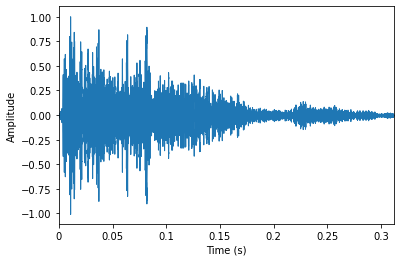

Negative sample: ../data/coughs_clean/norm_c792b5fc-37a5-43fb-aba7-8a5cdfb58b1e.wav_cut002.wav


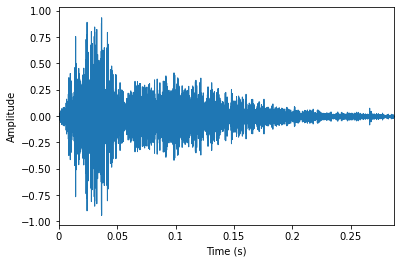

In [57]:
def plot_wave(x, sr):
    librosa.display.waveplot(x, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()    

pos = df[df.positive==True].iloc[1]
neg = df[df.positive==False].iloc[26]

print(f"Positive sample: {pos.filename}")
display(Audio(pos.filename))
yp, srp = librosa.load(f"{pos.filename}")
plot_wave(yp, srp)

print(f"Negative sample: {neg.filename}")
display(Audio(neg.filename))
yn, srn = librosa.load(f"{neg.filename}")
plot_wave(yn, srn)

Positive sample: ../data/coughs_clean/norm_9ae8463a-ed46-47ef-b7b7-97ae4016f0f2.wav_cut002.wav


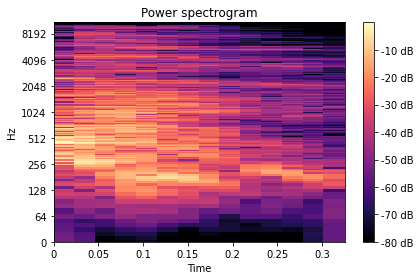

Negative sample: ../data/coughs_clean/norm_c792b5fc-37a5-43fb-aba7-8a5cdfb58b1e.wav_cut002.wav


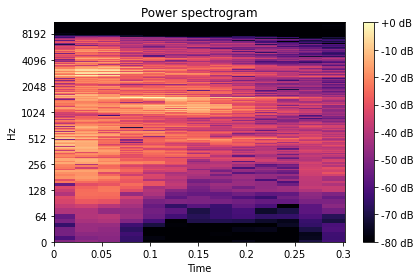

In [58]:
def plot_spec(x):
    x_stft = librosa.stft(x)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(x_stft), ref=np.max), y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

print(f"Positive sample: {pos.filename}")
plot_spec(yp)

print(f"Negative sample: {neg.filename}")
plot_spec(yn)

Positive sample: ../data/coughs_clean/norm_9ae8463a-ed46-47ef-b7b7-97ae4016f0f2.wav_cut002.wav


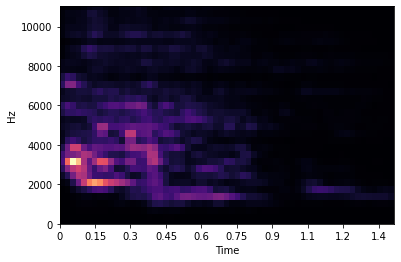

Negative sample: ../data/coughs_clean/norm_c792b5fc-37a5-43fb-aba7-8a5cdfb58b1e.wav_cut002.wav


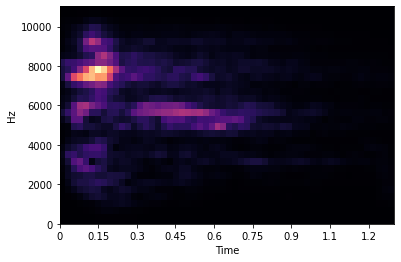

In [63]:
from src.preprocessing import GammatoneFilterbank

def plot_gf(x, sr):
    window_time = 0.01
    hop_time = window_time / 2
    num_filters = 32
    cutoff_low = 20

    gf = GammatoneFilterbank(sr,
                             window_time,
                             hop_time,
                             num_filters,
                             cutoff_low)

    gfs = gf.make_spectrogram(x)
    librosa.display.specshow(gfs, y_axis='linear', x_axis='time')
    plt.show()

print(f"Positive sample: {pos.filename}")
plot_gf(yp, srp)

print(f"Negative sample: {neg.filename}")
plot_gf(yn, srn)

## Classification

### Old fanshioned feature engineering

In [177]:
import scipy
from tqdm import tqdm

sample_rate = 22000
window_time = 0.01
hop_time = window_time / 2
num_filters = 32
cutoff_low = 20

gf = GammatoneFilterbank(sample_rate,
                         window_time,
                         hop_time,
                         num_filters,
                         cutoff_low)

Xv, yv = [], []
for Xc, yc in tqdm(list(zip(df.filename, df.positive))):
    try:
        y, sr = librosa.load(Xc, sr=22000)
        
        features = []

        features.append(np.mean(abs(y)))
        features.append(np.std(y))
        features.append(scipy.stats.skew(abs(y)))
        features.append(scipy.stats.kurtosis(y))

        zcr = librosa.feature.zero_crossing_rate(y + 0.0001, frame_length=2048, hop_length=512)[0]
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        rms = librosa.feature.rms(y + 0.0001)[0]
        features.append(np.mean(rms))
        features.append(np.std(rms))
        
        tempo = librosa.beat.tempo(y, sr=sr)
        features.extend(tempo)

        spectral_centroids = librosa.feature.spectral_centroid(y+0.01, sr=sr)[0]
        features.append(np.mean(spectral_centroids))
        features.append(np.std(spectral_centroids))

        spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=2)[0]
        spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)[0]
        spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)[0]
        features.append(np.mean(spectral_bandwidth_2))
        features.append(np.std(spectral_bandwidth_2))
        features.append(np.mean(spectral_bandwidth_3))
        features.append(np.std(spectral_bandwidth_3))
        features.append(np.mean(spectral_bandwidth_3))
        features.append(np.std(spectral_bandwidth_3))

        spectral_contrast = librosa.feature.spectral_contrast(y, sr=sr, n_bands = 6, fmin = 200.0)
        features.extend(np.mean(spectral_contrast, axis=1))
        features.extend(np.std(spectral_contrast, axis=1))

        spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr, roll_percent = 0.85)[0]
        features.append(np.mean(spectral_rolloff))
        features.append(np.std(spectral_rolloff))

        mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)
        features.extend(np.mean(mfccs, axis=1))
        features.extend(np.std(mfccs, axis=1))

        chroma_stft = librosa.feature.chroma_stft(y, sr=sr, hop_length=1024)
        features.extend(np.mean(chroma_stft, axis=1))
        features.extend(np.std(chroma_stft, axis=1))
        
        gammatone_stft = gf.make_spectrogram(y)
        features.extend(np.mean(gammatone_stft, axis=1))
        features.extend(np.std(gammatone_stft, axis=1))
        
        features = np.round(features, decimals=6)
        Xv.append(features)
        yv.append(int(yc))
        
    except ValueError as e:
        print(e)

 15%|█▌        | 105/699 [00:04<00:27, 21.99it/s]/Users/alessandromarin/Documents/projects/covid-19-classifier/venv/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
100%|██████████| 699/699 [00:31<00:00, 22.32it/s]


In [178]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# normalize
scalar = MinMaxScaler()
Xv = scalar.fit_transform(Xv)

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(Xv, yv, test_size=0.3)

In [186]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

class_weights = dict(Counter(y_train))
cls = SVC(C=1.0, class_weight=class_weights, max_iter=50000, kernel='linear')
cls.fit(X_train, y_train)

preds = cls.predict(X_test)

print(classification_report(y_test, preds, target_names=['negative', 'positive']))


cls = RandomForestClassifier(n_estimators=500, class_weight=class_weights, min_samples_split=5)
cls.fit(X_train, y_train)

preds = cls.predict(X_test)
print(classification_report(y_test, preds, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.94      0.93      0.93       194
    positive       0.22      0.25      0.24        16

    accuracy                           0.88       210
   macro avg       0.58      0.59      0.58       210
weighted avg       0.88      0.88      0.88       210

              precision    recall  f1-score   support

    negative       0.92      1.00      0.96       194
    positive       0.00      0.00      0.00        16

    accuracy                           0.92       210
   macro avg       0.46      0.50      0.48       210
weighted avg       0.85      0.92      0.89       210



/Users/alessandromarin/Documents/projects/covid-19-classifier/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
